## AUTO-ENCODER ONLY: FIRST TRY

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sonnia.processing import Processing


In [39]:
df = pd.read_table('peptide-detail-ci.csv', sep=',')
sample = df.sample(1000)
print(len(sample))
print(sample.columns)
sample.head(3)

1000
Index(['TCR BioIdentity', 'TCR Nucleotide Sequence', 'Experiment',
       'ORF Coverage', 'Amino Acids', 'Start Index in Genome',
       'End Index in Genome'],
      dtype='object')


,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome
84113,CASSHHAGNSETQYF+TCRBV12-X+TCRBJ02-05,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,eHO141,ORF3a,ALSKGVHFV,25606,25632
33358,CASAIGLAGQETQYF+TCRBV12-05+TCRBJ02-05,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTATTTTTGTGCTAGTG...,eXL27,ORF1ab,KLWAQCVQL,11921,11947
2151,CASRNSWDPRSSYEQYF+TCRBV07-02+TCRBJ02-07,ACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTGCCAGCAGAAATA...,eOX52,ORF1ab,"APKEIIFL,KEIIFLEGETL",2468,2506


In [40]:
for i in sample.index:
    sequence = sample.loc[i,"TCR BioIdentity"].split("+")
    sample.loc[i, "amino_acid"] = sequence[0]
    sample.loc[i, "v_gene"] = sequence[1]
    sample.loc[i, "j_gene"] = sequence[2]
sample[["amino_acid", "v_gene", "j_gene"]].head(3)
processor = Processing(chain_type = "humanTRB")
filtered = processor.filter_dataframe(sample[['amino_acid', 'v_gene', 'j_gene']])
data_seqs = list(filtered.values.astype(np.str))
df = pd.DataFrame(data_seqs, columns=['amino_acid', 'v_gene', 'j_gene'])
df

bad genes: 179
unproductive: 4
wrong bounds: 5
long cdr3s: 0


<ipython-input-40-3d5e69f64c44>:9: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_seqs = list(filtered.values.astype(np.str))


,amino_acid,v_gene,j_gene
0,CASAIGLAGQETQYF,TRBV12-5,TRBJ2-5
1,CASRNSWDPRSSYEQYF,TRBV7-2,TRBJ2-7
2,CASSPRVQGRSYNSPLHF,TRBV5-6,TRBJ1-6
3,CASSLSVGTGYYEQYF,TRBV5-4,TRBJ2-7
4,CASSWGGSDIQYF,TRBV7-6,TRBJ2-4
...,...,...,...
807,CASSLEQGAYEQYF,TRBV5-4,TRBJ2-7
808,CASSNSYEQYF,TRBV4-1,TRBJ2-7
809,CASSGSYEQYF,TRBV2,TRBJ2-7
810,CASTLPRQGGTDTQYF,TRBV7-8,TRBJ2-3


In [41]:
from deepchem.feat.smiles_tokenizer import SmilesTokenizer
import os
df.loc[0, 'tokenized'] = ""
tokenizer = SmilesTokenizer("./vocab.txt")
for i in df.index:
    df.loc[i,"tokenized"] = list(tokenizer.encode(str(df.loc[i,"amino_acid"])))

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [42]:
df.head(3)

,amino_acid,v_gene,j_gene,tokenized
0,CASAIGLAGQETQYF,TRBV12-5,TRBJ2-5,"[12, 16, 34, 48, 27, 13]"
1,CASRNSWDPRSSYEQYF,TRBV7-2,TRBJ2-7,"[12, 16, 34, 23, 34, 45, 34, 34, 27, 13]"
2,CASSPRVQGRSYNSPLHF,TRBV5-6,TRBJ1-6,"[12, 16, 34, 34, 45, 34, 23, 34, 45, 27, 13]"


In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [44]:
samples_8 = df[df["tokenized"].map(len) == 8]
batch = samples_8["tokenized"]
values = np.stack(batch.to_numpy())
X_train = tf.constant(values)

In [45]:
samples_8

,amino_acid,v_gene,j_gene,tokenized
4,CASSWGGSDIQYF,TRBV7-6,TRBJ2-4,"[12, 16, 34, 34, 34, 48, 27, 13]"
8,CASSQIAGKAEAFF,TRBV4-2,TRBJ1-1,"[12, 16, 34, 34, 48, 27, 27, 13]"
9,CASSQTGGAYNEQFF,TRBV4-1,TRBJ2-1,"[12, 16, 34, 34, 23, 27, 27, 13]"
12,CAIGTGNNEQFF,TRBV24-1,TRBJ2-1,"[12, 16, 48, 23, 23, 27, 27, 13]"
13,CASSLSRTSQETQYF,TRBV11-2,TRBJ2-5,"[12, 16, 34, 34, 34, 34, 27, 13]"
...,...,...,...,...
794,CASSPGGELSGETQYF,TRBV4-2,TRBJ2-5,"[12, 16, 34, 34, 45, 34, 27, 13]"
796,CASSQEAGGANTEAFF,TRBV5-4,TRBJ1-1,"[12, 16, 34, 34, 23, 27, 27, 13]"
798,CASSIGGTEAFF,TRBV19,TRBJ1-1,"[12, 16, 34, 34, 48, 27, 27, 13]"
802,CASSLVAGGPGSTDTQYF,TRBV5-1,TRBJ2-3,"[12, 16, 34, 34, 45, 34, 27, 13]"


In [46]:
n_inputs = 8
print(len(X_train))
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)
# define bottleneck
n_bottleneck = 2
bottleneck = Dense(n_bottleneck)(e)
# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=0)

195


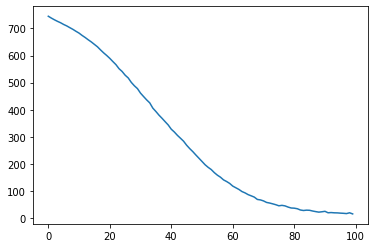

In [47]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')

In [48]:
encoder = Model(inputs=visible, outputs=bottleneck)

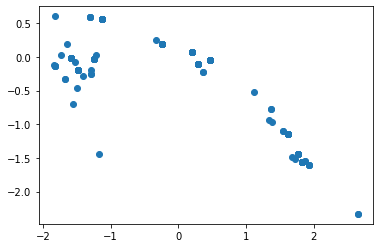

In [49]:
X_train_encode = encoder.predict(X_train)
plt.scatter(X_train_encode[:,0], X_train_encode[:,1])

In [50]:
import pandas as pd
from tcrdist.repertoire import TCRrep

In [51]:
df

,amino_acid,v_gene,j_gene,tokenized
0,CASAIGLAGQETQYF,TRBV12-5,TRBJ2-5,"[12, 16, 34, 48, 27, 13]"
1,CASRNSWDPRSSYEQYF,TRBV7-2,TRBJ2-7,"[12, 16, 34, 23, 34, 45, 34, 34, 27, 13]"
2,CASSPRVQGRSYNSPLHF,TRBV5-6,TRBJ1-6,"[12, 16, 34, 34, 45, 34, 23, 34, 45, 27, 13]"
3,CASSLSVGTGYYEQYF,TRBV5-4,TRBJ2-7,"[12, 16, 34, 34, 34, 27, 13]"
4,CASSWGGSDIQYF,TRBV7-6,TRBJ2-4,"[12, 16, 34, 34, 34, 48, 27, 13]"
...,...,...,...,...
807,CASSLEQGAYEQYF,TRBV5-4,TRBJ2-7,"[12, 16, 34, 34, 27, 13]"
808,CASSNSYEQYF,TRBV4-1,TRBJ2-7,"[12, 16, 34, 34, 23, 34, 27, 13]"
809,CASSGSYEQYF,TRBV2,TRBJ2-7,"[12, 16, 34, 34, 34, 27, 13]"
810,CASTLPRQGGTDTQYF,TRBV7-8,TRBJ2-3,"[12, 16, 34, 45, 27, 13]"


In [52]:
import pandas as pd
from tcrdist.repertoire import TCRrep


tr = TCRrep(cell_df = df, 
            organism = 'human', 
            chains = ['alpha','beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

c:\Users\yanis\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
c:\Users\yanis\anaconda3\lib\site-packages\tcrdist\repertoire.py:755: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
c:\Users\yanis\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a column called 'cdr3_a_aa' to track the CDR3 amino acid sequence

  self._validate_cell_df()
c:\Users\yanis\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a column called 'v_a_gene' for default functions

  self._validate_cell_df()
c:\Users\yanis\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a column called 'cdr3_b_aa' to track the CDR3 amino acid sequence

  self._validate_cell_df()
c:\Users\yanis\anaconda3\lib\site-packages\tcrdist\repertoire.py:

AttributeError: 'DataFrame' object has no attribute 'v_a_gene'

In [20]:
print(tr.pw_beta)

[[  0 162  90 ... 120  75  75]
 [162   0 123 ...  96 126 138]
 [ 90 123   0 ...  81 120 120]
 ...
 [120  96  81 ...   0  69  69]
 [ 75 126 120 ...  69   0  12]
 [ 75 138 120 ...  69  12   0]]
